In [0]:


import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.sql import DataFrame
from pyspark.sql.functions import col, when, count


TABLE_NAME = "airbnb.raw.listings" 
try:
    spark_df = spark.read.table(TABLE_NAME)
except Exception as e:
    print(f"Помилка завантаження таблиці '{TABLE_NAME}'.")
    print(e)
    raise(e)



def collect_missing_stats(spark_df: DataFrame):
    """
    Збирає статистику про пропущені значення у Spark DataFrame,
    коректно обробляючи різні типи даних.
    """
    total_rows = spark_df.count()
    if total_rows == 0:
        return pd.DataFrame(columns=['column', 'missing_count', 'missing_percentage']), pd.DataFrame()

    missing_count_exprs = []
    nullity_matrix_exprs = []
    

    for col_name, col_type in spark_df.dtypes:
        

        if col_type == 'string':

            missing_condition = col(col_name).isNull() | (col(col_name) == '')
        else:

            missing_condition = col(col_name).isNull()
        


        missing_count_exprs.append(
            count(when(missing_condition, 1)).alias(col_name)
        )
        

        nullity_matrix_exprs.append(
            when(missing_condition, 1).otherwise(0).alias(col_name)
        )


    missing_counts_dict = spark_df.select(missing_count_exprs).first().asDict()
    
    stats_df = pd.DataFrame(
        missing_counts_dict.items(),
        columns=['column', 'missing_count']
    )
    stats_df['missing_percentage'] = (stats_df['missing_count'] / total_rows) * 100
    stats_df = stats_df.sort_values(by='missing_count', ascending=False)
    
    nullity_matrix_pd = spark_df.select(nullity_matrix_exprs).toPandas()

    return stats_df, nullity_matrix_pd



columns_to_analyze = [
    'host_is_superhost',
    'review_scores_rating',
    'review_scores_accuracy',
    'review_scores_cleanliness',
    'review_scores_checkin',
    'review_scores_communication',
    'review_scores_location',
    'review_scores_value',
    'reviews_per_month',
    'bathrooms',
    'bedrooms',
    'beds'
]

existing_columns = [c for c in columns_to_analyze if c in spark_df.columns]
if not existing_columns:
    print(f"Жоден із цільових стовпців {columns_to_analyze} не знайдено в таблиці. Перевірте назви стовпців.")
else:
    df_subset = spark_df.select(existing_columns)

    print("Збираємо статистику... Це може зайняти хвилину.")
    stats_df, nullity_matrix_pd = collect_missing_stats(df_subset)

    print("Статистика готова. Можна переходити до візуалізації.")
    display(stats_df)

Збираємо статистику... Це може зайняти хвилину.
Статистика готова. Можна переходити до візуалізації.


column,missing_count,missing_percentage
bathrooms,12955,100.0
review_scores_value,1972,15.221922037823235
review_scores_checkin,1970,15.20648398301814
review_scores_communication,1970,15.20648398301814
review_scores_location,1970,15.20648398301814
review_scores_accuracy,1969,15.198764955615593
review_scores_cleanliness,1969,15.198764955615593
reviews_per_month,1956,15.098417599382477
review_scores_rating,1953,15.075260517174835
bedrooms,1499,11.570822076418372


/home/spark-c60463d9-e2fb-4218-940d-ea/.ipykernel/2447/command-5728405986964180-1056018095:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


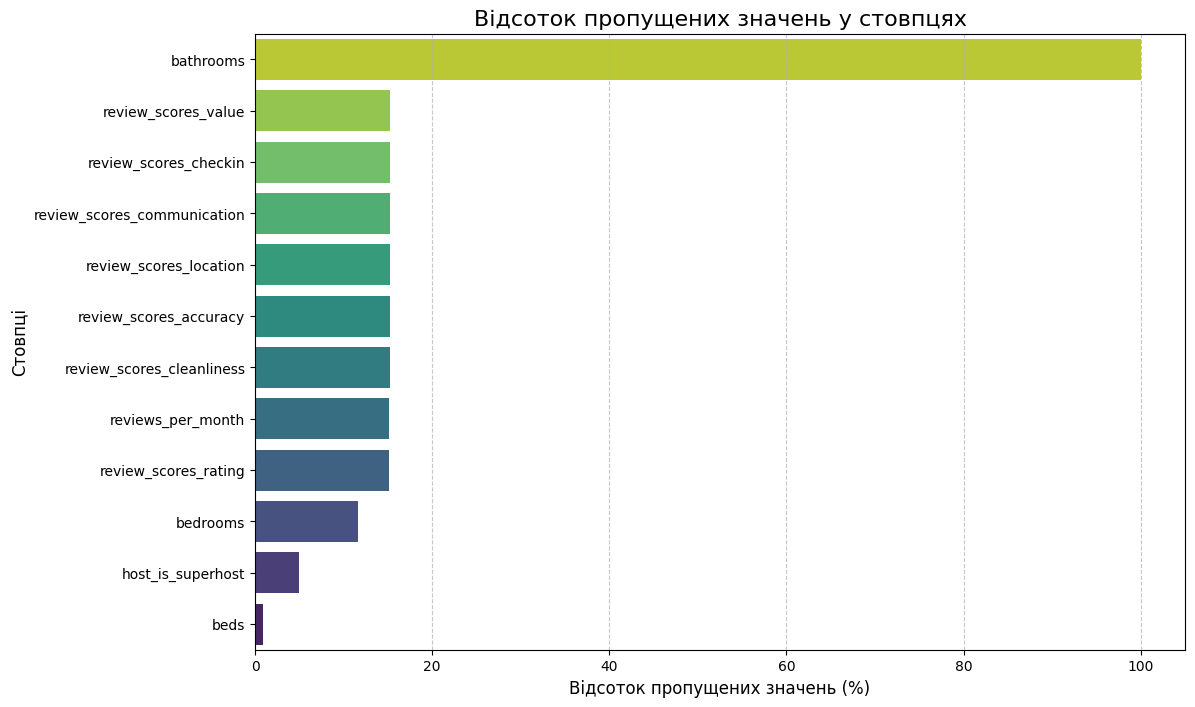

In [0]:


def plot_missing_count_bar(stats_df: pd.DataFrame):
    """Будує гістограму кількості пропущених значень."""
    data_to_plot = stats_df[stats_df['missing_count'] > 0]
    
    if data_to_plot.empty:
        print("Чудові новини! У вибраних стовпцях немає пропущених значень.")
        return

    plt.figure(figsize=(12, 8))
    sns.barplot(
        x='missing_percentage', 
        y='column', 
        data=data_to_plot,
        palette='viridis_r'
    )
    plt.title('Відсоток пропущених значень у стовпцях', fontsize=16)
    plt.xlabel('Відсоток пропущених значень (%)', fontsize=12)
    plt.ylabel('Стовпці', fontsize=12)
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    display(plt.gcf()) 
    plt.close()

# Малюємо графік
plot_missing_count_bar(stats_df)

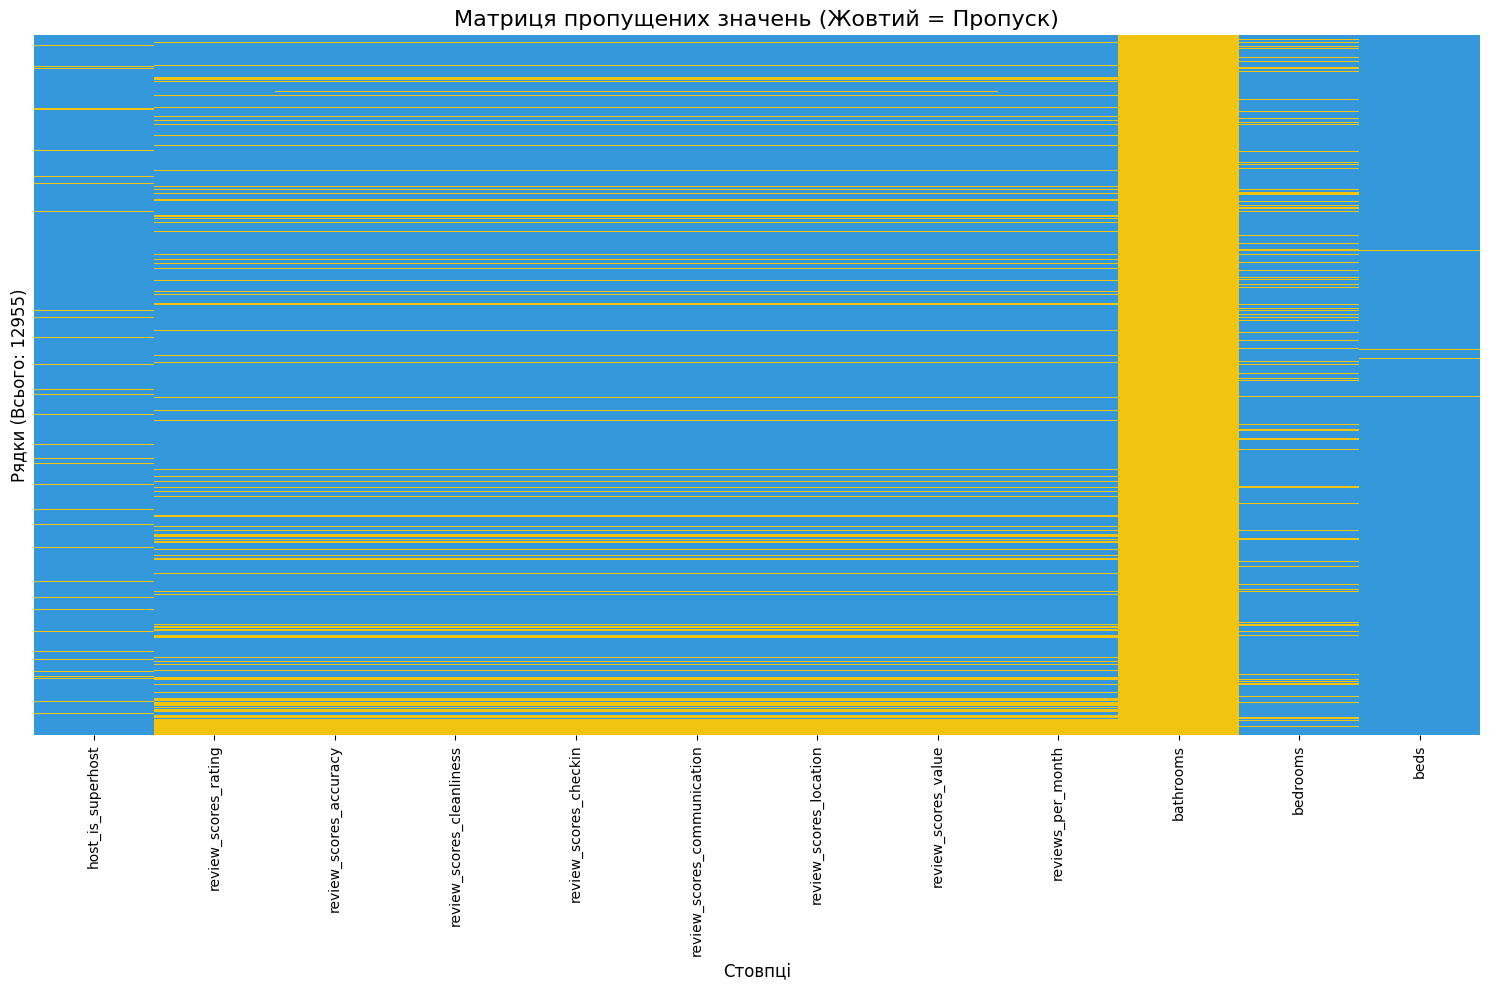

In [0]:


def plot_missing_matrix(nullity_matrix_pd: pd.DataFrame):
    """Будує матрицю пропущених значень."""
    cols_with_missing = nullity_matrix_pd.columns[nullity_matrix_pd.sum() > 0]
    
    if cols_with_missing.empty:
        print("Немає стовпців з пропусками для побудови матриці.")
        return

    plt.figure(figsize=(15, 10))
    sns.heatmap(
        nullity_matrix_pd[cols_with_missing], 
        cmap=['#3498db', '#f1c40f'], # Синій - дані є, Жовтий - пропуск
        cbar=False
    )
    plt.title('Матриця пропущених значень (Жовтий = Пропуск)', fontsize=16)
    plt.xlabel('Стовпці', fontsize=12)
    plt.ylabel(f'Рядки (Всього: {len(nullity_matrix_pd)})', fontsize=12)
    plt.yticks([]) 
    plt.tight_layout()
    display(plt.gcf())
    plt.close()

# Малюємо графік
plot_missing_matrix(nullity_matrix_pd)

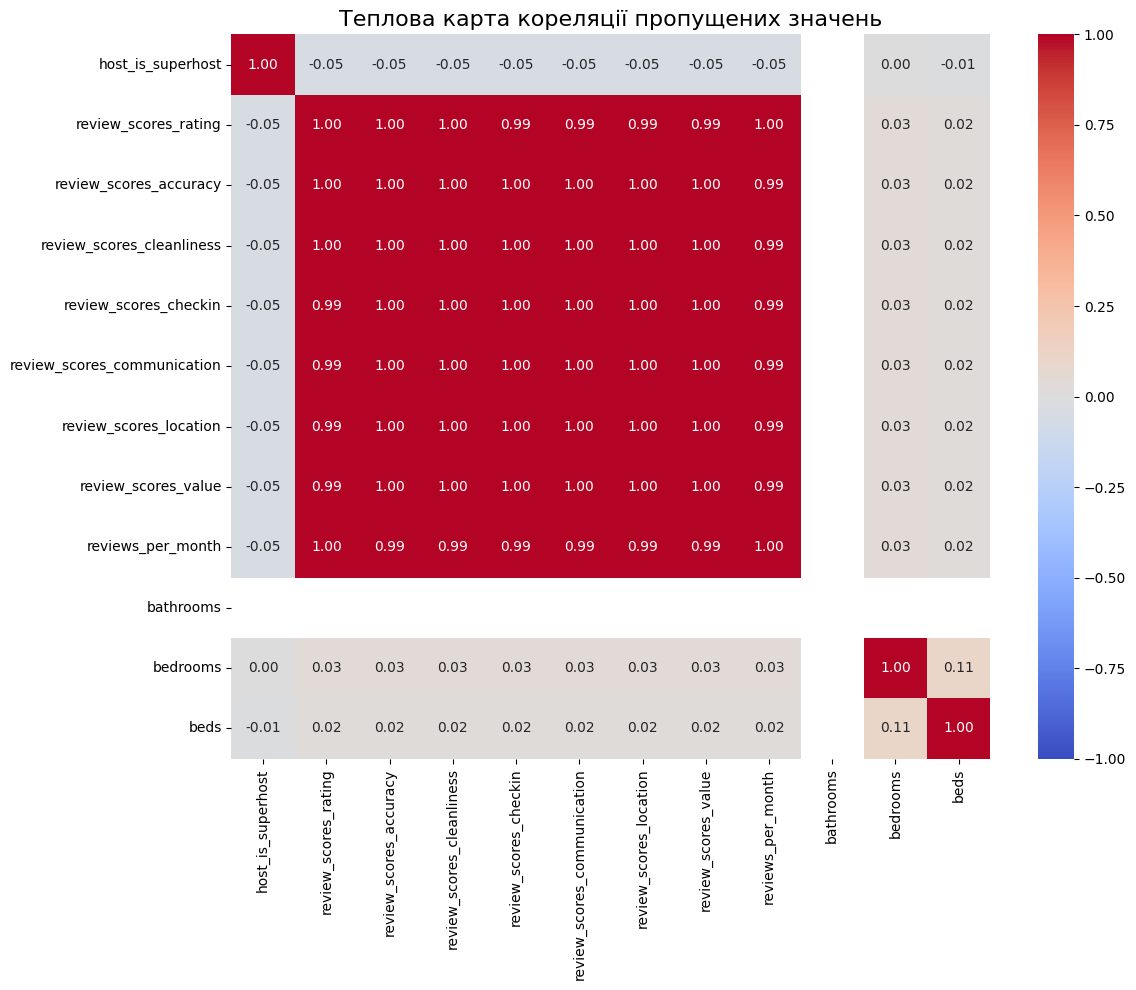

In [0]:


def plot_nullity_correlation_heatmap(nullity_matrix_pd: pd.DataFrame):
    """Будує теплову карту кореляції пропусків."""
    cols_with_missing = nullity_matrix_pd.columns[nullity_matrix_pd.sum() > 0]
    
    if len(cols_with_missing) < 2:
        print("Недостатньо стовпців з пропусками для побудови кореляційної матриці.")
        return

    correlation_matrix = nullity_matrix_pd[cols_with_missing].corr()
    
    plt.figure(figsize=(12, 10))
    sns.heatmap(
        correlation_matrix, 
        annot=True, 
        cmap='coolwarm',
        vmin=-1, vmax=1,
        fmt='.2f'
    )
    plt.title('Теплова карта кореляції пропущених значень', fontsize=16)
    plt.tight_layout()
    display(plt.gcf())
    plt.close()

# Малюємо графік
plot_nullity_correlation_heatmap(nullity_matrix_pd)